In [1]:
from anndata import AnnData
import scanpy as sc
import squidpy as sq
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix # imports the csr_matrix function from the scipy.sparse module


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import scipy

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

In [2]:
mpl.rcParams['figure.dpi'] = 450

Set parameters

In [3]:
neighbors = 15
fineNeighborhood = 4
coarseNeighborhood = 3

colors = {"DCT": "#800515",
               "Endothelium": "#7ae031",
               "UB_CT": "black",
               "Podocyte": "#ad9c00", 
               "Stroma": "#794b82",
               "NPC": "#ff8000", 
               "PT": "#ff00d4", 
               "Int": "#698cff",
               "Ureth": "#d47222", 
               "PEC": "#ff0011", 
               "LOH": "#235e00",
               "Immune Cells": '#757575',
               "Nephron":"#698cff",
         }

In [4]:
adata = sc.read_h5ad("/home/levinsj/spatial/adata/project_Files/Fetal/model2/fetal_PostSCANVI_imputedExpression.h5ad")
adata = adata[adata.obs["tech"] == "CosMx"]
print(adata)

adata_UB = sc.read_h5ad("/home/levinsj/spatial/adata/project_Files/Fetal/model2/fetal_PostSCANVI_Abs_UB_Only.h5ad")
adata_UB = adata_UB[adata_UB.obs["UB_absorption_SCVI"] > 0.5]

common_obs_idx = adata.obs_names.intersection(adata_UB.obs_names)
adata = adata[~adata.obs_names.isin(common_obs_idx)]

print(adata)


View of AnnData object with n_obs × n_vars = 377959 × 24485
    obs: 'sample', 'phase', 'type', 'cellType', 'cellType3', 'tech', 'cellType_CosMx_1', 'leiden', 'fov', 'cell_ID', 'pct_counts_mt', 'pct_nuc', 'total_counts', 'nCount_RNA', 'n_genes_by_counts', 'CenterX_global_px', 'CenterY_global_px', 'Area', 'Count_percentile', 'Mean.DAPI', 'Max.DAPI', 'G2M_score', 'S_score', 'gAge', 'AllCounts', '_scvi_batch', '_scvi_labels', 'mean_distance', 'worst_pct', 'cellType_SCANVI', 'leiden_sub18', 'neighbors', 'Endothelium_neighbor', 'UB_CT_neighbor', 'Stroma_neighbor', 'Podocyte_neighbor', 'PT_neighbor', 'PEC_neighbor', 'LOH_neighbor', 'Int_neighbor', 'DCT_neighbor', 'Immune Cells_neighbor', 'Ureth_neighbor', 'DCT_absorbtion_SCVI', 'LOH_absorbtion_SCVI', 'PT_absorbtion_SCVI', 'Podo_absorbtion_SCVI', 'NPC_SCVI', 'Differentiated Cell_SCVI', 'Tubule_SCVI', 'Glomerular_SCVI', 'LatentTime_SCVI', 'PseudoTime_SCVI'
    uns: 'phase_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_scANVI', 'X_scVI', 'X_uma

In [5]:
print(adata.obs_names)

Index(['1_1-0', '2_1-0', '3_1-0', '4_1-0', '5_1-0', '6_1-0', '7_1-0', '8_1-0',
       '9_1-0', '10_1-0',
       ...
       '1468_69-2', '1472_69-2', '1473_69-2', '1477_69-2', '1478_69-2',
       '1482_69-2', '1490_69-2', '1491_69-2', '1493_69-2', '1494_69-2'],
      dtype='object', length=357886)


In [6]:
adata1 = sc.read_h5ad("/home/levinsj/spatial/adata/project_Files/Fetal/ligandScores_all_ligands.h5ad")


In [7]:
print(adata1.obs_names)

Index(['4_1-1', '5_1-1', '8_1-1', '35_1-1', '36_1-1', '39_1-1', '40_1-1',
       '42_1-1', '43_1-1', '45_1-1',
       ...
       '2906_220-0', '2907_220-0', '2908_220-0', '2909_220-0', '2910_220-0',
       '2913_220-0', '2916_220-0', '2918_220-0', '2919_220-0', '2920_220-0'],
      dtype='object', length=377959)


In [8]:
adata1.obs["renew"] = adata.obs["NPC_SCVI"]
adata1.obs["dif"] = adata.obs['Differentiated Cell_SCVI']

adata1.obs["podocyte"] = adata.obs["Podo_absorbtion_SCVI"]
adata1.obs["pt"] = adata.obs["PT_absorbtion_SCVI"]
adata1.obs["loh"] = adata.obs["LOH_absorbtion_SCVI"]
adata1.obs["dct"] = adata.obs["DCT_absorbtion_SCVI"]

adata1.obs["tubule"] = adata.obs["Tubule_SCVI"]
adata1.obs["glom"] = adata.obs["Glomerular_SCVI"]

adata1.obs["pseudo"] = adata.obs["PseudoTime_SCVI"]
adata1.obs["cellType"] = adata.obs["cellType"]


print(adata1)
print(adata1.obs["renew"])

adata1 = adata1[~adata1.obs["renew"].isna()]


AnnData object with n_obs × n_vars = 377959 × 878
    obs: 'sample', 'renew', 'dif', 'podocyte', 'pt', 'loh', 'dct', 'tubule', 'glom', 'pseudo', 'cellType'
    uns: 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
4_1-1         0.043285
5_1-1         0.056756
8_1-1         0.136873
35_1-1        0.100813
36_1-1        0.013909
                ...   
2913_220-0         NaN
2916_220-0         NaN
2918_220-0         NaN
2919_220-0    0.010042
2920_220-0    0.006251
Name: renew, Length: 377959, dtype: float64


In [9]:
renew_correlations = []
dif_correlations = []

podo_correlations = []
pt_correlations = []
loh_correlations = []
dct_correlations = []

tubule_correlations = []
glom_correlations = []

pseudo_correlation = []

for i in range(adata1.shape[1]):
    gene_expression = adata1.X[:, i].toarray().flatten()
    gene_expression = gene_expression[~np.isnan(gene_expression)]
    renew = adata1.obs["renew"][~np.isnan(gene_expression)]
    dif = adata1.obs["dif"][~np.isnan(gene_expression)]
    
    pt = adata1.obs["pt"][~np.isnan(gene_expression)]
    podo = adata1.obs["podocyte"][~np.isnan(gene_expression)]
    loh = adata1.obs["loh"][~np.isnan(gene_expression)]
    dct = adata1.obs["dct"][~np.isnan(gene_expression)]

    tubule = adata1.obs["tubule"][~np.isnan(gene_expression)]
    glom = adata1.obs["glom"][~np.isnan(gene_expression)]
    
    pseudo = adata1.obs["pseudo"][~np.isnan(gene_expression)]

    
    # Calculate correlations
    correlation_renew = np.corrcoef(gene_expression, renew)[0, 1]
    correlation_dif = np.corrcoef(gene_expression, dif)[0, 1]
    
    correlation_pt = np.corrcoef(gene_expression, pt)[0, 1]
    correlation_podo = np.corrcoef(gene_expression, podo)[0, 1]
    correlation_loh = np.corrcoef(gene_expression, loh)[0, 1]
    correlation_dct = np.corrcoef(gene_expression, dct)[0, 1]

    correlation_glom = np.corrcoef(gene_expression, glom)[0, 1]
    correlation_tub = np.corrcoef(gene_expression, tubule)[0, 1]
    
    correlation_pseudo = np.corrcoef(gene_expression, pseudo)[0, 1]
    
    renew_correlations.append(correlation_renew)
    dif_correlations.append(correlation_dif)
    
    pt_correlations.append(correlation_pt)
    podo_correlations.append(correlation_podo)
    loh_correlations.append(correlation_loh)
    dct_correlations.append(correlation_dct)
    
    glom_correlations.append(correlation_glom)
    tubule_correlations.append(correlation_tub)

    pseudo_correlation.append(correlation_pseudo)

df = pd.DataFrame({'Ligand': adata1.var_names.tolist(), 'Renew': renew_correlations, "Diff": dif_correlations,
                  "PT": pt_correlations, "Podocyte": podo_correlations, "LOH": loh_correlations, "DCT": dct_correlations,
                  "Tubule": tubule_correlations, "Glom": glom_correlations, "PseudoTime": pseudo_correlation})

print(df)

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


    Ligand     Renew      Diff        PT  Podocyte       LOH       DCT  \
0     ACE2 -0.157377  0.141251  0.503422 -0.193547 -0.075269 -0.113056   
1    ACKR1       NaN       NaN       NaN       NaN       NaN       NaN   
2    ACKR2 -0.038337  0.031189 -0.011395 -0.079729  0.112494  0.027442   
3    ACKR3 -0.241737  0.221895 -0.116095  0.368391 -0.159354 -0.294658   
4    ACKR4 -0.081680  0.073520 -0.011380  0.051735 -0.004946 -0.061390   
..     ...       ...       ...       ...       ...       ...       ...   
873   XCL1  0.007898 -0.004700  0.010429  0.000715 -0.010772 -0.000049   
874   XCL2  0.002213 -0.002070  0.015066 -0.003520 -0.006968 -0.002678   
875   XCR1 -0.021201  0.019904 -0.002601  0.018267 -0.006374 -0.018512   
876   XPR1 -0.062261  0.074292  0.369586 -0.109647 -0.109952 -0.073635   
877   YARS  0.111429 -0.090807 -0.041198 -0.007477  0.012721  0.041185   

       Tubule      Glom  PseudoTime  
0    0.196858 -0.193547    0.230658  
1         NaN       NaN         NaN

In [10]:
df.to_csv('/home/levinsj/spatial/adata/project_Files/Fetal/ligandCorr.csv')


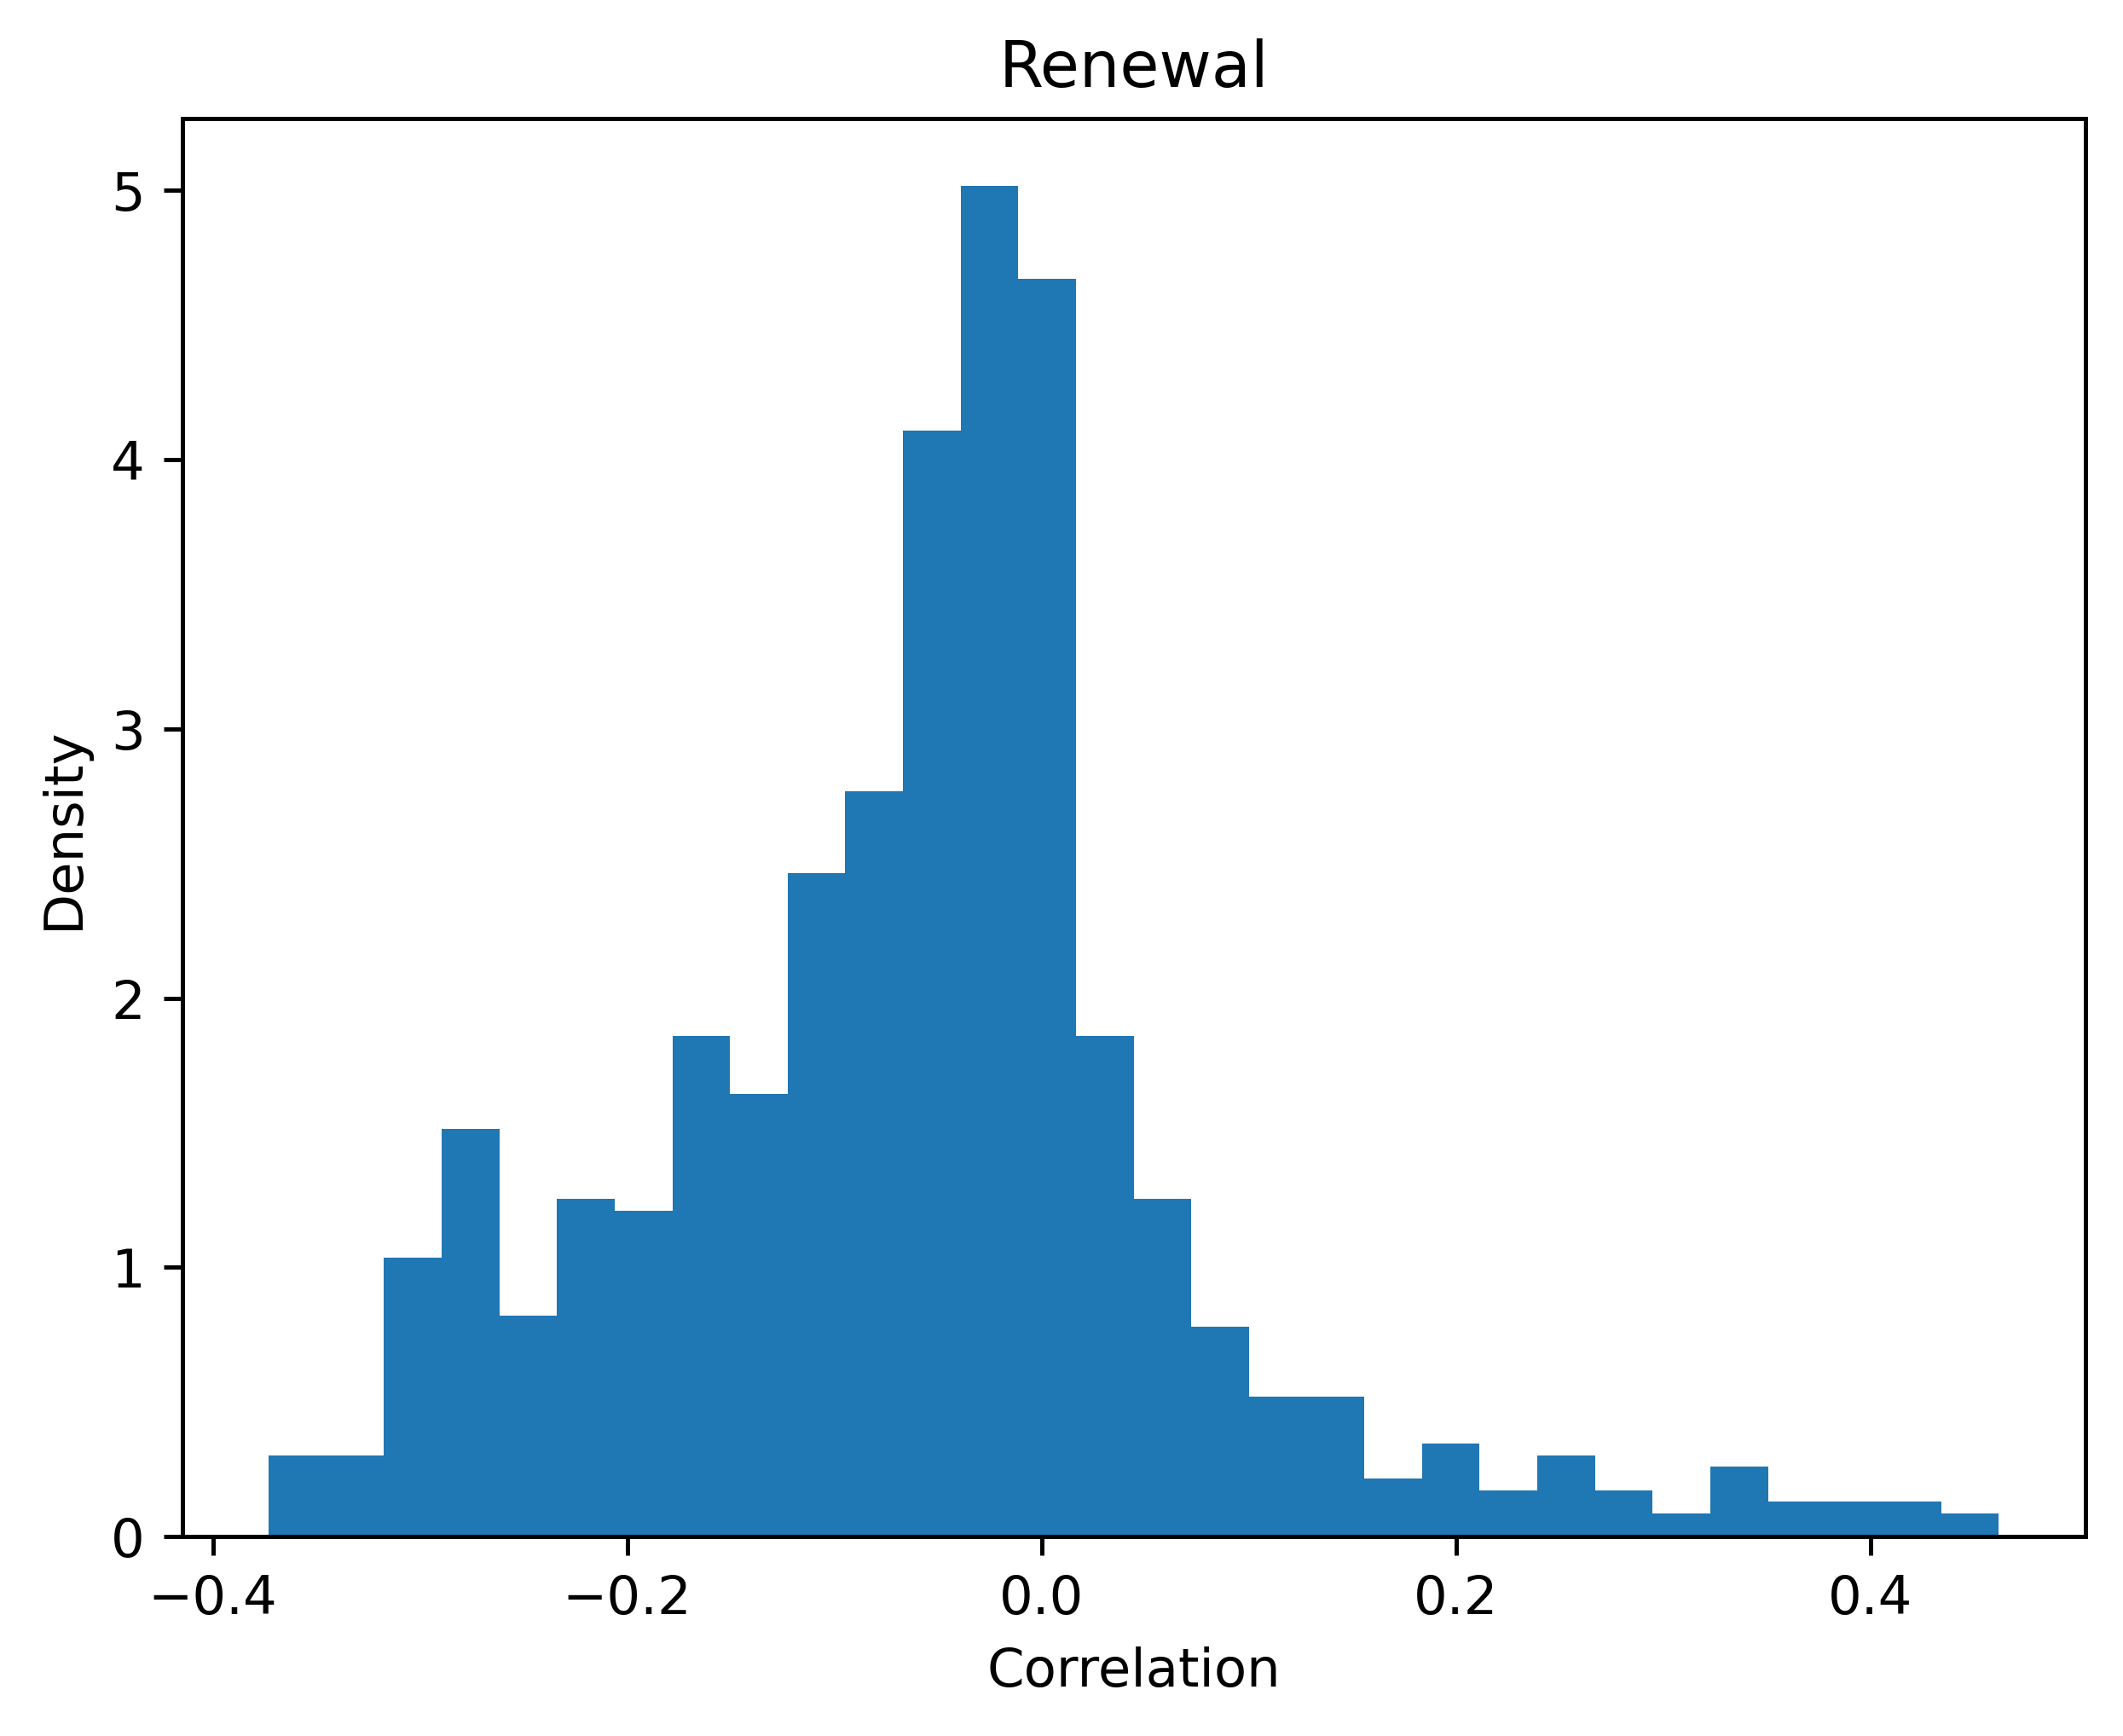

In [11]:
plt.hist(df['Renew'], bins=30, density=True)

# Annotate specific observations (replace with your actual indices)

#igf2_index = df.iloc[df['Ligand'] == "P01344"].index[0]
#gdnf_index = df.iloc[df['Ligand'] == "P56159"].index[0]#

#plt.annotate("IGF2", xy=(df['Renew'][igf2_index], 0.05), xytext=(5, 5), textcoords="offset points", arrowprops=dict(arrowstyle="->"))
#lt.annotate("GDNF", xy=(df['Renew'][gdnf_index], 0.05), xytext=(-5, 5), textcoords="offset points", arrowprops=dict(arrowstyle="->"))

# Customize the plot (optional)
plt.title("Renewal")
plt.xlabel("Correlation")
plt.ylabel("Density")

# Show the plot
plt.show()